<a href="https://colab.research.google.com/github/emreozeren/Uskudar_Unv_SGI/blob/main/Yapay_Sinir_Aglari_Final_Odevi_234329046_Emre_Ozeren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.image as mpimg
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import kagglehub
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import Sequential
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, RandomFlip, RandomRotation
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
veri_yolu = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Veri seti yolu:", veri_yolu)

Veri seti yolu: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [ ]:
train_dataset = keras.utils.image_dataset_from_directory(
    directory='/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    verbose=True
)

Found 7553 files belonging to 2 classes.


In [ ]:
# train_dataset kullanılarak bir dataframe oluşturulması

sinif_isimleri = train_dataset.class_names
sinif_sayisi = len(sinif_isimleri)

# Veri kümesinden görüntü yollarının ve etiketlerin çıkarılması
goruntu_dizini = []
etiketler = []
for goruntuler, etiket in train_dataset:
    for i in range(len(goruntuler)):
        goruntu_dizini.append(goruntuler[i].numpy()) # Append the image tensor itself
        etiketler.append(etiket[i].numpy())

# Dataframe oluşturulması
train_df = pd.DataFrame({'Goruntu': goruntu_dizini, 'Etiket': etiketler})
print(train_df.head())


                                             Goruntu  Etiket
0  [[[245.0, 249.0, 250.0], [245.0, 249.0, 250.0]...       0
1  [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...       0
2  [[[139.0, 116.0, 100.0], [134.80469, 111.80469...       1
3  [[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0], [4.029297,...       0
4  [[[162.0, 167.0, 161.0], [161.03516, 166.03516...       1


In [ ]:
#Veri setinin TRAIN (EĞİTİM), VALIDATE (DOĞRULAMA) ve TEST olarak bölünmesi

train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Etiket'])
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42, stratify=train_df['Etiket']) # 0.125 x 0.8 = 0.1

print("Eğitim veri seti boyutu:", len(train_df))
print("Doğrulama veri seti boyutu:", len(val_df))
print("Test veri seti boyutu:", len(test_df))


Eğitim veri seti boyutu: 5286
Doğrulama veri seti boyutu: 756
Test veri seti boyutu: 1511


In [ ]:
# Eğitim veri setinin datagen (ImageDataGenerator) kullanılarak artırılması

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Görüntü tensörünün PIL Görüntüsüne dönüştürülmesi
def tensoru_goruntuye_donusturme(tensor):
    tensor = tensor.astype('uint8')
    return Image.fromarray(tensor)

# Artırılmış eğitim verilerinin oluşturulması
artirilmis_goruntuler = []
artirilmis_etiketler = []
for index, satir in train_df.iterrows():
    goruntu = tensoru_goruntuye_donusturme(satir['Goruntu'])
    etiket = satir['Etiket']

    # Görüntünün büyütülmek için diziye dönüştürülmesi
    x = img_to_array(goruntu)
    x = x.reshape((1,) + x.shape)

    # Geçerli görüntü için artırılmış görüntüler oluşturulması
    for paket in datagen.flow(x, batch_size=1):
        artirilmis_goruntu = paket[0].astype('uint8')  # Convert back to uint8
        artirilmis_goruntuler.append(artirilmis_goruntu)
        artirilmis_etiketler.append(etiket)
        break

# Artırılmış veriler için yeni bir DataFrame oluşturulması
augmented_df = pd.DataFrame({'Goruntu': artirilmis_goruntuler, 'Etiket': artirilmis_etiketler})

# Artırılmış verilerin orijinal eğitim verileriyle birleştirilmesi
train_df = pd.concat([train_df, augmented_df], ignore_index=True)

print("Artırılmış veri seti boyutu:", len(train_df))


Artırılmış veri seti boyutu: 10572


In [ ]:
print("ARTIRILMIŞ Eğitim veri seti boyutu:", len(train_df))
print("Doğrulama veri seti boyutu:", len(val_df))
print("Test veri seti boyutu:", len(test_df))

ARTIRILMIŞ Eğitim veri seti boyutu: 10572
Doğrulama veri seti boyutu: 756
Test veri seti boyutu: 1511


In [ ]:
# prompt: Yukarıda önceki hücrede tanımlanmış iki sınıflı veri setini kullanarak Önceden Eğitilmiş (Pre-trained) Modellerin Hazırlanması için; Sınıflandırıcı olarak DenseNet201 kullan. Base modelleri indirdikten sonra  2 DENSE LAYER ekle ve 1 DROPOUT LAYER ekle.

goruntu_boyutu = (256, 256, 3)
base_model = DenseNet201(input_shape=goruntu_boyutu, include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 8, 8, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 122880)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      31,457,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,812,674 (190.02 MB)

 Trainable params: 31,490,690 (120.13 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

**DENSENET201 Kullanılması nedeniyle ilgili modelin parametreleri incelendiğinde:**

**DenseNet201**: DenseNet ailesinden 201 katmanlı önceden eğitilmiş bir modeldir.

**input_shape**=goruntu_boyutu: Görüntülerin girdi şeklini belirtmektedir (örneğin, 224x224 boyutundaki RGB görüntüleri için (224, 224, 3)).

**include_top**=False: Ağın en üstündeki tam bağlı katmanları hariç tutarak özel katmanlar eklenmesine olanak tanımaktadır.

**weights**='imagenet': Modeli ImageNet veri kümesinden önceden eğitilmiş ağırlıklarla başlatmak için belirlenmiş bir parametredir.

**base_model.trainable** = False: Temel modelin ağırlıklarını dondurmaktadır, yani eğitim sırasında güncellenmezler. Bu, önceden eğitilmiş özellikleri korunmak istendiğinde transfer öğrenmesi için kullanılmaktadır.

---

**Sequential**: Doğrusal bir katman yığınıdır.

**Flatten()**: Temel modelden gelen çıktıyı 1 boyutlu bir vektöre düzleştirmektedir.

**Dense(256, activation='relu')**: 256 birim ve ReLU aktivasyonu ile tam bağlı bir katman eklemektedir.

**Dropout(0.5)**: Aşırı uyumu önlemek için %50 bırakma oranıyla bırakma düzenlemesi uygulanması için belirlenen parametredir.

**Dense(128, activation='relu')**: 128 birim ve ReLU aktivasyonu ile başka bir tam bağlı katman eklemektedir.

**Dense(2, aktivasyon='softmax')**: Her sınıf için olasılıklar üretmek üzere 2 üniteli (ikili sınıflandırma için) ve softmax aktivasyonlu çıktı katmanı eklenmiştir. Sonuçlar bizim örneğimizde "maskeli" ve "maskesiz" olarak 2 sınıfa ayrıldığı için sona bu katman eklenmiştir.

Epoch 1/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 121s 227ms/step - accuracy: 0.9615 - loss: 0.6048 - val_accuracy: 0.9921 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 2/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9878 - loss: 0.0541 - val_accuracy: 0.9947 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 3/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9899 - loss: 0.0472 - val_accuracy: 0.9947 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 4/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9904 - loss: 0.0370 - val_accuracy: 0.9960 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 5/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9895 - loss: 0.0586 - val_accuracy: 0.9960 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 6/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9897 - loss: 0.0388 - val_accuracy: 0.9921 - val_loss: 0.0643 - learning_rate: 0.0010
Epoch 7/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0

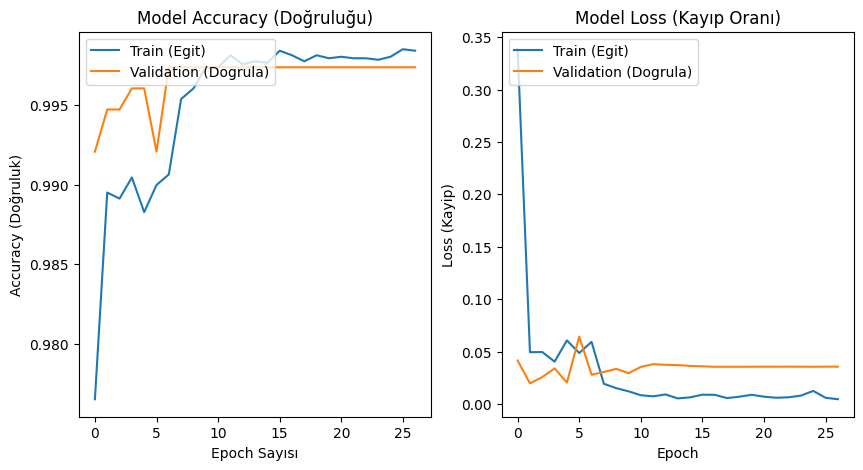

In [ ]:
# Eğitim ve doğrulama için 'image' sütununun float32 dtype ile NumPy dizisine dönüştürülmesi
x_train = np.array([img_to_array(tensoru_goruntuye_donusturme(img)) for img in train_df['Goruntu'].values]).astype('float32') / 255.0
x_val = np.array([img_to_array(tensoru_goruntuye_donusturme(img)) for img in val_df['Goruntu'].values]).astype('float32') / 255.0

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    x=x_train,
    y=keras.utils.to_categorical(train_df['Etiket'].values, num_classes=2),
    validation_data=(x_val, keras.utils.to_categorical(val_df['Etiket'].values, num_classes=2)),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (Doğruluğu)')
plt.ylabel('Accuracy (Doğruluk)')
plt.xlabel('Epoch Sayısı')
plt.legend(['Train (Egit)', 'Validation (Dogrula)'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (Kayıp Oranı)')
plt.ylabel('Loss (Kayip)')
plt.xlabel('Epoch')
plt.legend(['Train (Egit)', 'Validation (Dogrula)'], loc='upper left')
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


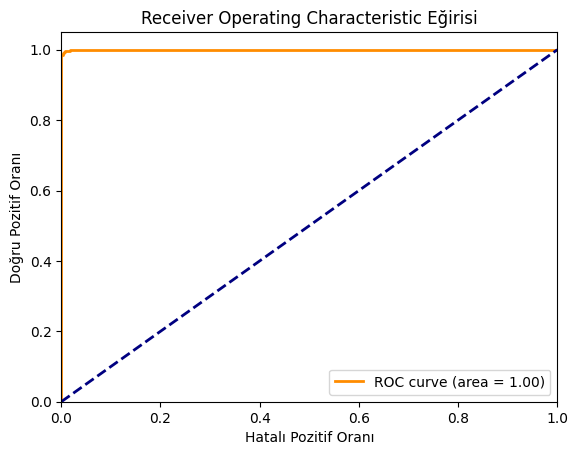

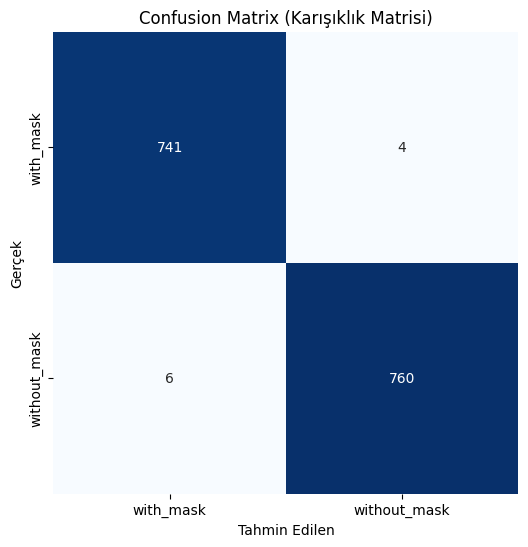

Accuracy (Doğruluk): 0.9934
Precision (Kesinlik): 0.9948
Recall (Hassasiyet): 0.9922
Specificity (Özgüllük): 0.9946
F1-score: 0.9935

Sınıflandırma Raporu:
               precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       745
without_mask       0.99      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



In [ ]:
# Test için 'Goruntu' sütununun float32 dtype ile NumPy dizisine dönüştürülmesi
x_test = np.array([img_to_array(tensoru_goruntuye_donusturme(img)) for img in test_df['Goruntu'].values]).astype('float32') / 255.0
y_test = test_df['Etiket'].values

# Test seti için olasılıkların tahmin edilmesi
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)


# ROC Eğrisi ve Area Under Curve(AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Hatalı Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('Receiver Operating Characteristic Eğirisi')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=sinif_isimleri, yticklabels=sinif_isimleri)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix (Karışıklık Matrisi)')
plt.show()

# Diğer Metrikler
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
f1 = f1_score(y_test, y_pred)


print(f"Accuracy (Doğruluk): {accuracy:.4f}")
print(f"Precision (Kesinlik): {precision:.4f}")
print(f"Recall (Hassasiyet): {recall:.4f}")
print(f"Specificity (Özgüllük): {specificity:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred, target_names=sinif_isimleri))


ROC Eğrisi (Receiver Operating Characteristic Curve) ve Eğri Altında Kalan Alan (Area Under Curve), sınıflandırma modellerinin performansını değerlendirmek için kullanılan önemli metriklerdir. Özellikle ikili (binary) sınıflandırma problemlerinde modelin ne kadar iyi çalıştığını anlamak için yaygın olarak kullanılmaktadırlar.

**1. ROC Eğrisi (ROC Curve)**
ROC eğrisi, bir sınıflandırma modelinin performansını görselleştirmek için kullanılan bir grafiktir. Eğri, True Positive Rate (TPR) ve False Positive Rate (FPR) arasındaki ilişkiyi gösterir.

True Positive Rate (TPR) veya Sensitivity (Duyarlılık):
Modelin pozitif sınıfı ne kadar iyi tanımladığını gösterir. Yüksek TPR, modelin pozitif örnekleri doğru bir şekilde sınıflandırdığını ifade eder.

False Positive Rate (FPR):
Modelin negatif sınıfı yanlışlıkla pozitif olarak sınıflandırma oranını gösterir. Düşük FPR, modelin negatif örnekleri doğru bir şekilde sınıflandırdığını ifade eder.

ROC eğrisi, farklı sınıflandırma eşik değerleri (threshold) için TPR ve FPR değerlerini çizer. Eğri, sol üst köşeye ne kadar yakınsa, modelin performansı o kadar iyidir.

**2. Eğri Altında Kalan Alan (Area Under Curve)**
AUC, ROC eğrisinin altında kalan alanın ölçüsüdür. Değeri 0 ile 1 arasında değişir ve modelin sınıflandırma yeteneğini özetler.

AUC = 1: Mükemmel sınıflandırma. Model, pozitif ve negatif örnekleri tamamen doğru bir şekilde ayırt edebiliyor.

AUC = 0.5: Rastgele tahmin. Modelin tahminleri, rastgele bir tahminle aynıdır.

AUC < 0.5: Model, sınıfları tersine çevirerek tahmin yapıyor (bu durumda modelin tahminlerini tersine çevirerek performansı artırabilirsiniz).

AUC, özellikle dengesiz veri setlerinde (örneğin, bir sınıfın diğerinden çok daha fazla olduğu durumlarda) modelin performansını değerlendirmek için kullanışlıdır.

**ROC Eğrisi ve AUC'nin Avantajları**
Eşik Değerinden Bağımsızdır: ROC eğrisi ve AUC, sınıflandırma eşik değerinden bağımsız olarak modelin genel performansını değerlendirir.

Dengesiz Veri Setlerinde Kullanışlıdır: Accuracy (doğruluk) gibi metrikler, dengesiz veri setlerinde yanıltıcı olabilir. ROC ve AUC, bu tür durumlarda daha güvenilirdir.

Karşılaştırma Kolaylığı: Farklı modellerin ROC eğrilerini ve AUC değerlerini karşılaştırarak hangisinin daha iyi performans gösterdiğini kolayca anlayabilirsiniz.



**Accuracy (Doğruluk)**: 0.9934. Modelin tüm tahminlerinin doğru olma oranıdır. %99.34 doğruluk, modelin genel olarak çok iyi performans gösterdiğini belirtir.

**Precision (Kesinlik)**: 0.9948. Modelin pozitif olarak tahmin ettiği örneklerin ne kadarının gerçekten pozitif olduğunu gösterir. %99.48 kesinlik, modelin yanlış pozitifler (False Positives) üretme olasılığının çok düşük olduğunu belirtir.

**Recall (Hassasiyet)**: 0.9922. Gerçek pozitif örneklerin ne kadarının doğru bir şekilde tanımlandığını gösterir. %99.22 hassasiyet, modelin gerçek pozitifleri yakalama konusunda çok başarılı olduğunu belirtir.

**Specificity (Özgüllük)**: 0.9946. Gerçek negatif örneklerin ne kadarının doğru bir şekilde tanımlandığını gösterir. %99.46 özgüllük, modelin yanlış negatifler (False Negatives) üretme olasılığının çok düşük olduğunu belirtir.

**F1-Score**: 0.9935. Precision ve Recall'un harmonik ortalamasıdır. %99.35 F1-Score, modelin hem kesinlik hem de hassasiyet açısından dengeli bir performans sergilediğini belirtir.


Bu modelin çalışma sonuçlarındaki tüm metrikler (Accuracy, Precision, Recall, Specificity, F1-Score) %99 civarında. Bu, modelin hem pozitif hem de negatif sınıfları çok iyi bir şekilde ayırt edebildiğini göstermektedir.

Hem maskeli hem de maskesiz sınıflar için Precision, Recall ve F1-Score değerleri birbirine yakın olduğu için, modelin dengeli bir performans sergilediği söylenebilir.

Maskeli (745 örnek) ve maskesiz (766 örnek) sınıfların sayıları birbirine yakın olması; Accuracy'nin güvenilir bir metrik olduğunu göstermektedir.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 8, 8, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 122880)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      31,457,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,812,674 (190.02 MB)

 Trainable params: 33,354,370 (127.24 MB)

 Non-trainable params: 16,458,304 (62.78 MB)

Epoch 1/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 106s 193ms/step - accuracy: 0.9928 - loss: 0.0361 - val_accuracy: 0.9921 - val_loss: 0.0343 - learning_rate: 1.0000e-04
Epoch 2/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9956 - loss: 0.0182 - val_accuracy: 0.9974 - val_loss: 0.0189 - learning_rate: 1.0000e-04
Epoch 3/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9966 - loss: 0.0107 - val_accuracy: 0.9974 - val_loss: 0.0188 - learning_rate: 1.0000e-04
Epoch 4/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9989 - loss: 0.0029 - val_accuracy: 0.9921 - val_loss: 0.0401 - learning_rate: 1.0000e-04
Epoch 5/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.9980 - loss: 0.0045 - val_accuracy: 0.9960 - val_loss: 0.0329 - learning_rate: 1.0000e-04
Epoch 6/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9960 - val_loss: 0.0410 - learning_rate: 1.0000e-04
Epoch 7/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 14s

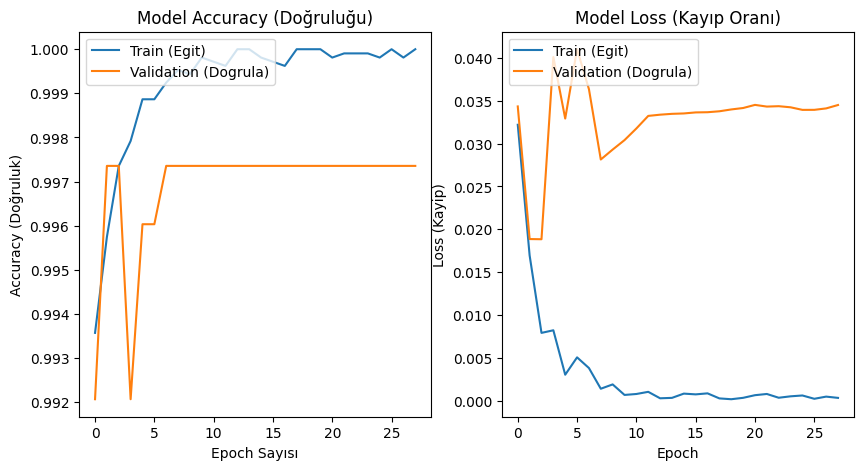

In [ ]:
# Şimdi son 50 dense seviyesinin freeze özelliği kaldırılmıştır (layer.trainable = True). Bu kez bu modelin kendine ait sondan 50 katmanı da kullanılarak bir ince ayar eğitimi yapıldığında...

for layer in base_model.layers[-50:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# İnce ayar (fine tune) eğitimde derste konuştuğumuz üzere learning rate bu kez daha düşük tutulmuştur. (1.0000e-04)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    x=x_train,
    y=keras.utils.to_categorical(train_df['Etiket'].values, num_classes=2),
    validation_data=(x_val, keras.utils.to_categorical(val_df['Etiket'].values, num_classes=2)),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (Doğruluğu)')
plt.ylabel('Accuracy (Doğruluk)')
plt.xlabel('Epoch Sayısı')
plt.legend(['Train (Egit)', 'Validation (Dogrula)'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (Kayıp Oranı)')
plt.ylabel('Loss (Kayip)')
plt.xlabel('Epoch')
plt.legend(['Train (Egit)', 'Validation (Dogrula)'], loc='upper left')
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 413ms/step


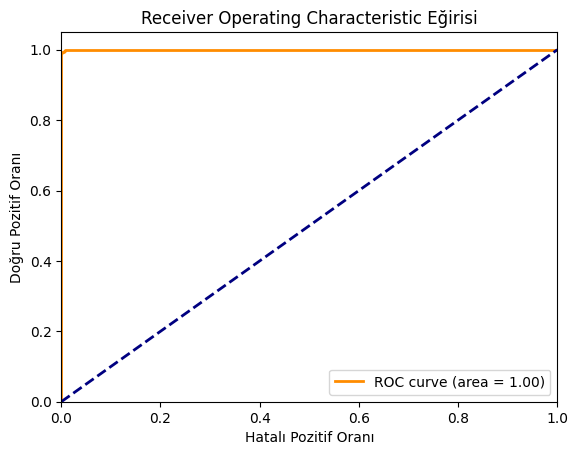

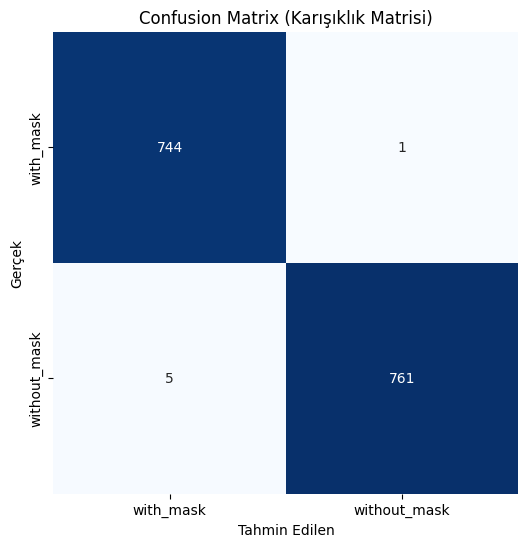

Accuracy (Doğruluk): 0.9960
Precision (Kesinlik): 0.9987
Recall (Hassasiyet): 0.9935
Specificity (Özgüllük): 0.9987
F1-score: 0.9961

Sınıflandırma Raporu:
               precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       745
without_mask       1.00      0.99      1.00       766

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



In [ ]:
# Test için 'Goruntu' sütununun float32 dtype ile NumPy dizisine dönüştürülmesi
x_test = np.array([img_to_array(tensoru_goruntuye_donusturme(img)) for img in test_df['Goruntu'].values]).astype('float32') / 255.0
y_test = test_df['Etiket'].values

# Test seti için olasılıkların tahmin edilmesi
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)


# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])  # Use probabilities for positive class
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Hatalı Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('Receiver Operating Characteristic Eğirisi')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=sinif_isimleri, yticklabels=sinif_isimleri)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix (Karışıklık Matrisi)')
plt.show()

# Diğer Metrikler
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
f1 = f1_score(y_test, y_pred)


print(f"Accuracy (Doğruluk): {accuracy:.4f}")
print(f"Precision (Kesinlik): {precision:.4f}")
print(f"Recall (Hassasiyet): {recall:.4f}")
print(f"Specificity (Özgüllük): {specificity:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred, target_names=sinif_isimleri))

**Fine Tune öncesi (Model 1) ve Fine Tune sonrası (Model 2) sonuçlarının karşılaştırılması.**

**Accuracy (Doğruluk):**
Model 1: %99.34
Model 2: %99.60
Model 2, genel doğrulukta küçük bir artış göstermiştir. Bu, Model 2'nin daha az hata yaptığını gösterir.

**Precision (Kesinlik):**
Model 1: %99.48
Model 2: %99.87
Model 2, yanlış pozitifleri (False Positives) daha az üretmiştir. Bu, Model 2'nin pozitif tahminlerinin daha güvenilir olduğunu gösterir.

**Recall (Hassasiyet):**
Model 1: %99.22
Model 2: %99.35
Model 2, gerçek pozitifleri yakalama konusunda biraz daha iyidir. Bu, Model 2'nin daha az yanlış negatif (False Negatives) ürettiğini gösterir.

**Specificity (Özgüllük):**
Model 1: %99.46
Model 2: %99.87
Model 2, gerçek negatifleri tanımlama konusunda önemli ölçüde daha iyidir. Bu, Model 2'nin daha az yanlış pozitif (False Positives) ürettiğini gösterir.

**F1-Score:**
Model 1: %99.35
Model 2: %99.61
Model 2, Precision ve Recall arasında daha iyi bir denge sağlamıştır. Bu, Model 2'nin hem kesinlik hem de hassasiyet açısından daha dengeli bir performans sergilediğini gösterir.

Sonuç olarak;
Model 2, tüm metriklerde Model 1'e göre küçük ama önemli iyileştirmeler göstermiştir. Özellikle Specificity ve Precision metriklerindeki artış, Model 2'nin yanlış pozitifleri ve yanlış negatifleri daha az ürettiğini gösterir. F1-Score'daki artış, Model 2'nin hem kesinlik hem de hassasiyet açısından daha dengeli bir performans sergilediğini belirtir.

**Fine Tune öncesi (Model 1) ve Fine Tune sonrası (Model 2) sonuçlarının Model Doğruluk Eğrileri Analizi**

**Model 1:**
Eğitim doğruluğu (accuracy) 0,98 civarında başlamakta ve 0,99'lara yükselmektedir.
Validation doğruluğu da oldukça yüksektir (0,995+ civarında). Ancak ilk epoklarda biraz daha fazla dalgalanma göstermektedir.
**Model 2:**
Eğitim doğruluğu hızla 0,99'un üzerine çıkıyor ve eğitimin orta noktasında ~1,0'a ulaşıyor.
Doğrulama doğruluğu 0,997-0,998 civarında stabilize olur.

**Kayıp Eğrileri Analizi**

**Model 1:**
Eğitim kaybı yaklaşık 5-8. epokta ~0,35'ten neredeyse sıfıra kadar dik bir şekilde düşmektedir ve ardından küçük değerlerle düz devam etmektedir.
Validation kaybının genel olarak eğitim kaybından daha yüksek olduğu görülmektedir (~0,04-0,05 mertebesinde).
**Model 2:**
Eğitim kaybı hızla düşmektedir (~0,04'ten neredeyse 0'a) ve son derece düşük devam etmektedir.
Validation kaybı 0,035-0,04 civarında başlamakta ve önce ilk birkaç epokta biraz sıçramakta ve ardından eğitimin geri kalanı için çoğunlukla 0,03-0,04 civarında düzleşmektedir.

Her iki model de son derece yüksek eğitim ve validation doğruluğuna (%99'un çok üzerinde) ulaşmaktadır.
**Model 1** için validation eğrileri ilk epoklarda biraz daha düzensizdir (küçük düşüşler/çıkışlar) ancak sonunda aynı yüksek doğruluğa ve düşük kayba yakınsamaktadır.
**Model 2** için ise eğitim doğruluğu ve kaybı çok güçlü bir uyum (mükemmel doğruluğa yaklaşma, sıfıra yakın kayıp) gösterirken, validation eğrisi biraz daha düşük (ancak yine de son derece yüksek) bir doğrulukta stabilize olmaktadır. Bu genellikle bir overfitting (aşırı uyumun) göstergesi olarak görülebilir.

Her iki modelde de eğitim kaybının hızla çok küçük değerlere düşmesi, modellerin hızlı öğrendiğini ve iyi yakınsadığı anlamına gelmektedir.

Pratik anlamda, her ikisi de mükemmele yakın doğrulukta performans göstermektedir, bu nedenle yalnızca son doğrulama ölçütlerine bakıldığında, neredeyse eşdeğer görünmektedirler.

Model 1 eğitim kaybını bu kadar çabuk sıfırlamadığı için biraz daha az overfitting (aşırı uyum) gösteriyor olabilir.

Model 2 mükemmele yakın eğitim sonuçları artı istikrarlı yüksek doğrulama doğruluğu göstermektedir.